<a href="https://colab.research.google.com/github/Nageswar-Sahoo/EVA-8/blob/main/assignment-3/assignment-part-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [72]:
train_transforms = transforms.Compose(
                    [
                  #  transforms.ToPILImage(),
                  #  transforms.RandomRotation(30),
                    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                  #  transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                   # transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])
# don't (really) need the data augmentation in validation
val_transforms = transforms.Compose(
                    [
                   # transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])
test_transforms = val_transforms

# Dataset and Creating Train/Test Split

In [73]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [74]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

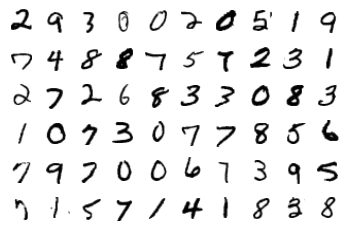

In [75]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [99]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5
         # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
    
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [100]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 26, 26]             135
       BatchNorm2d-2           [-1, 15, 26, 26]              30
              ReLU-3           [-1, 15, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]           1,350
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,440
       BatchNorm2d-8           [-1, 16, 22, 22]              32
              ReLU-9           [-1, 16, 22, 22]               0
          Dropout-10           [-1, 16, 22, 22]               0
        MaxPool2d-11           [-1, 16, 11, 11]               0
           Conv2d-12           [-1, 20, 11, 11]             320

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [101]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [102]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.12897346913814545 Batch_id=468 Accuracy=94.87: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]



Test set: Average loss: 0.0588, Accuracy: 9839/10000 (98.39%)

EPOCH: 1


Loss=0.05044789984822273 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 0.0502, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.04516749456524849 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0525, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.10639500617980957 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]



Test set: Average loss: 0.0365, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.04322616755962372 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0329, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.0555260069668293 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.014171485789120197 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]



Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.03942439332604408 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.005100681912153959 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]



Test set: Average loss: 0.0253, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.022845523431897163 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]



Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.018727263435721397 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]



Test set: Average loss: 0.0225, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.021055126562714577 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]



Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.08675726503133774 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.015095562674105167 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.016991261392831802 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]



Test set: Average loss: 0.0220, Accuracy: 9937/10000 (99.37%)



In [103]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06154009699821472 Batch_id=468 Accuracy=94.28: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]



Test set: Average loss: 0.0781, Accuracy: 9776/10000 (97.76%)

EPOCH: 1


Loss=0.06352577358484268 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]



Test set: Average loss: 0.0462, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.061227817088365555 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]



Test set: Average loss: 0.0421, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.02597949467599392 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 0.0370, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.049207258969545364 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]



Test set: Average loss: 0.0324, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.012168479152023792 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0250, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.010953995399177074 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]



Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.03300413861870766 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0268, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.01633136160671711 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.02192881517112255 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]



Test set: Average loss: 0.0234, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.016982192173600197 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]



Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.039656445384025574 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 26.06it/s]



Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.06268755346536636 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0216, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.03374871611595154 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]



Test set: Average loss: 0.0214, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.06565993279218674 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]



Test set: Average loss: 0.0213, Accuracy: 9942/10000 (99.42%)



In [104]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10048698633909225 Batch_id=468 Accuracy=94.11: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0708, Accuracy: 9795/10000 (97.95%)

EPOCH: 1


Loss=0.06538120657205582 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:18<00:00, 24.81it/s]



Test set: Average loss: 0.0550, Accuracy: 9840/10000 (98.40%)

EPOCH: 2


Loss=0.041570160537958145 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.0553, Accuracy: 9845/10000 (98.45%)

EPOCH: 3


Loss=0.17272484302520752 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]



Test set: Average loss: 0.0309, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.0910363495349884 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.050942178815603256 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]



Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.027491353452205658 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0244, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.04708470031619072 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]



Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.06533484905958176 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]



Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.04354104772210121 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.0509500615298748 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.12361913919448853 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]



Test set: Average loss: 0.0208, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.043095722794532776 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]



Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.051475897431373596 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:17<00:00, 26.32it/s]



Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.034586675465106964 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]



Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)



In [105]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0817243903875351 Batch_id=468 Accuracy=94.75: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0589, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.060309842228889465 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]



Test set: Average loss: 0.0428, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.04083966091275215 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0477, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.013409937731921673 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]



Test set: Average loss: 0.0283, Accuracy: 9923/10000 (99.23%)

EPOCH: 4


Loss=0.00970653910189867 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]



Test set: Average loss: 0.0282, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.024193502962589264 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0328, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.00590871274471283 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0269, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.04884713888168335 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0265, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.02342812530696392 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.0256, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.0747903510928154 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]



Test set: Average loss: 0.0241, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.0018882188014686108 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]



Test set: Average loss: 0.0226, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.008615431375801563 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0212, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.004233639221638441 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s]



Test set: Average loss: 0.0210, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.012407764792442322 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:19<00:00, 24.62it/s]



Test set: Average loss: 0.0227, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.006329413969069719 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]



Test set: Average loss: 0.0215, Accuracy: 9943/10000 (99.43%)



In [106]:

train_losses_numpy=[]
for a in train_losses:
  train_losses_numpy.append(a.cpu().item())

Text(0.5, 1.0, 'Test Accuracy')

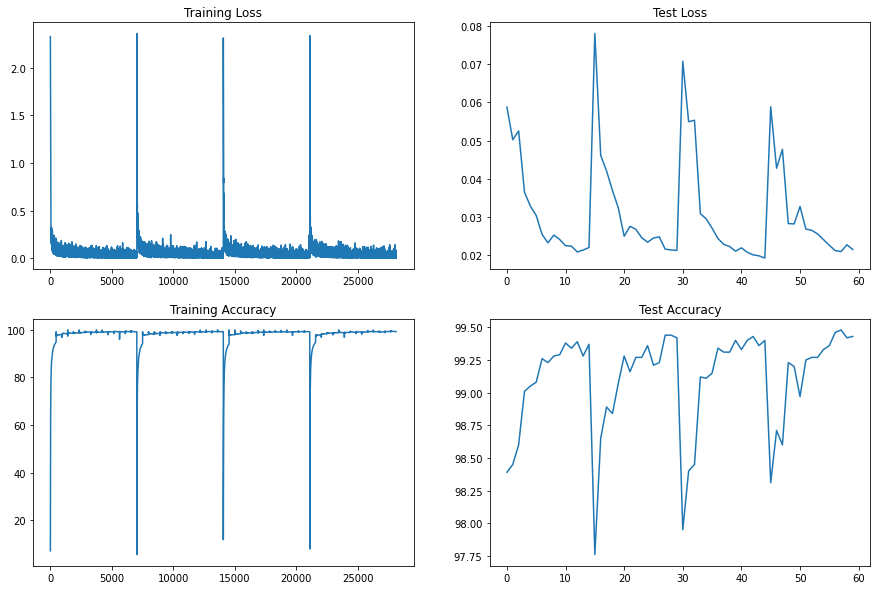

In [107]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_numpy)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [108]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.11837983131408691 Batch_id=468 Accuracy=94.82: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]



Test set: Average loss: 0.0788, Accuracy: 9762/10000 (97.62%)

EPOCH: 1


Loss=0.07320389896631241 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]



Test set: Average loss: 0.0443, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.08897977322340012 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0337, Accuracy: 9906/10000 (99.06%)

EPOCH: 3


Loss=0.00957188755273819 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]



Test set: Average loss: 0.0308, Accuracy: 9913/10000 (99.13%)

EPOCH: 4


Loss=0.07881269603967667 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]



Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.0710577666759491 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]



Test set: Average loss: 0.0249, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.0177477914839983 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.016253339126706123 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]



Test set: Average loss: 0.0231, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.06727872788906097 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]



Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


Loss=0.025941796600818634 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]



Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.028788819909095764 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.11681601405143738 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]



Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.05208037793636322 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 27.88it/s]



Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.03999881446361542 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]



Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.008970373310148716 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]



Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)



In [112]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04769285023212433 Batch_id=468 Accuracy=94.84: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0766, Accuracy: 9801/10000 (98.01%)

EPOCH: 1


Loss=0.04227369651198387 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]



Test set: Average loss: 0.0473, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


Loss=0.04268519952893257 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]



Test set: Average loss: 0.0452, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.029870525002479553 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]



Test set: Average loss: 0.0288, Accuracy: 9923/10000 (99.23%)

EPOCH: 4


Loss=0.051919903606176376 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.026531977578997612 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]



Test set: Average loss: 0.0293, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.04168672487139702 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]



Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.011213396675884724 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]



Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.009688136167824268 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]



Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.057361483573913574 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]



Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.02381567843258381 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0204, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.01638067327439785 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.03239172324538231 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]



Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.016828304156661034 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]



Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.0031423012260347605 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]



Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)



In [113]:

train_losses_numpy=[]
for a in train_losses:
  train_losses_numpy.append(a.cpu().item())

Text(0.5, 1.0, 'Test Accuracy')

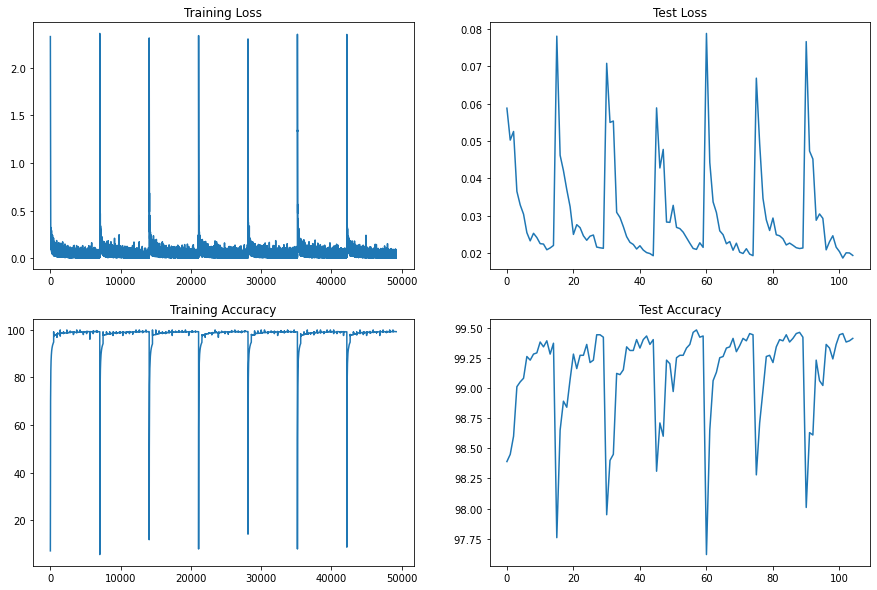

In [114]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_numpy)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [116]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0627978965640068 Batch_id=468 Accuracy=94.29: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]



Test set: Average loss: 0.0847, Accuracy: 9775/10000 (97.75%)

EPOCH: 1


Loss=0.04061983898282051 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0447, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.15947167575359344 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]



Test set: Average loss: 0.0357, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.029823988676071167 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]



Test set: Average loss: 0.0392, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.03451458364725113 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]



Test set: Average loss: 0.0284, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.0038897041231393814 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0264, Accuracy: 9935/10000 (99.35%)

EPOCH: 6


Loss=0.036396224051713943 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]



Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.0073137059807777405 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]



Test set: Average loss: 0.0249, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.02112927846610546 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.03333207592368126 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.033446360379457474 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]



Test set: Average loss: 0.0237, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.025623640045523643 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.033085357397794724 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0208, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.034282319247722626 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0203, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.017826272174715996 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]



Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

